In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.stattools import durbin_watson, jarque_bera
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pd.get_data_yahoo = pdr.get_data_yahoo
from pykalman import KalmanFilter
from numpy import log, polyfit, sqrt, std, subtract
import ffn

## Step 1: Fetch Historical Stock Data

In [2]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE', 'MSFT']


df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000
2018-12-28,223.130005,100.389999
2018-12-31,226.240005,101.570000


In [3]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

np.float64(0.04452696271616793)

## Step 2: Kalman Filtering


In [4]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [5]:
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [6]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

Hedge Ratios:
 Date
2013-01-02   -0.681331
2013-01-03   -0.689781
2013-01-04   -0.690096
2013-01-07   -0.689546
2013-01-08   -0.688060
                ...   
2018-12-24   -0.450154
2018-12-26   -0.449965
2018-12-27   -0.449623
2018-12-28   -0.449353
2018-12-31   -0.449021
Name: hr, Length: 1510, dtype: float64
Spread:
 Date
2013-01-02    0.816448
2013-01-03    0.522305
2013-01-04   -0.261997
2013-01-07   -0.159829
2013-01-08   -0.380776
                ...   
2018-12-24    1.063250
2018-12-26   -0.472779
2018-12-27   -0.761309
2018-12-28   -0.587156
2018-12-31   -0.729569
Name: spread, Length: 1510, dtype: float64


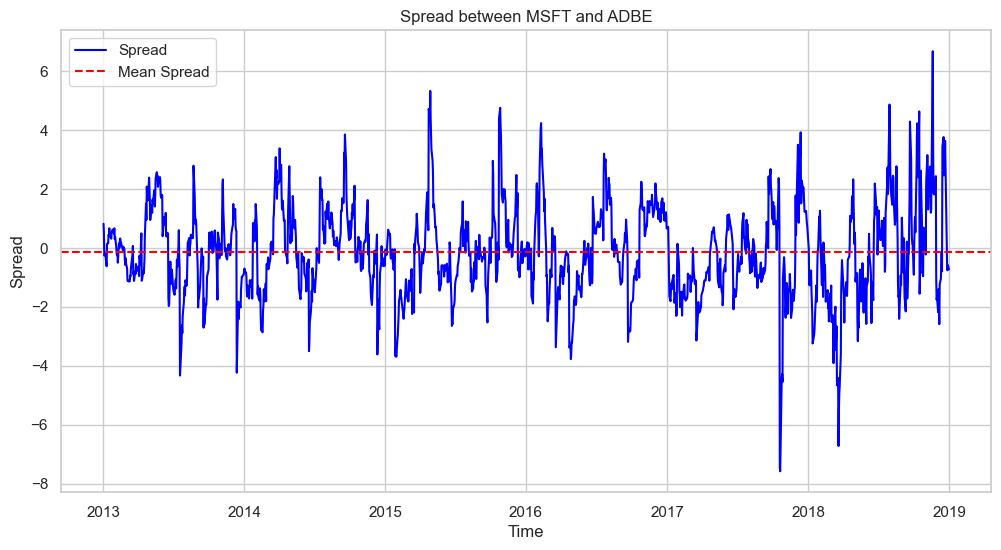

In [7]:
filtered_S1 = KalmanFilterAverage(S1)
filtered_S2 = KalmanFilterAverage(S2)
state_means = KalmanFilterRegression(filtered_S1, filtered_S2)

df['hr'] = -state_means[:, 0]
df['alpha_t'] = -state_means[:, 1]
df['spread'] = df['MSFT'] + (df['ADBE'] * df['hr']) + df['alpha_t']

print("Hedge Ratios:\n", df['hr'])
print("Spread:\n", df['spread'])

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread'], label='Spread', color='blue')
plt.axhline(df['spread'].mean(), color='red', linestyle='--', label='Mean Spread')
plt.title('Spread between MSFT and ADBE')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

## Step 3: Generate Trading Signals

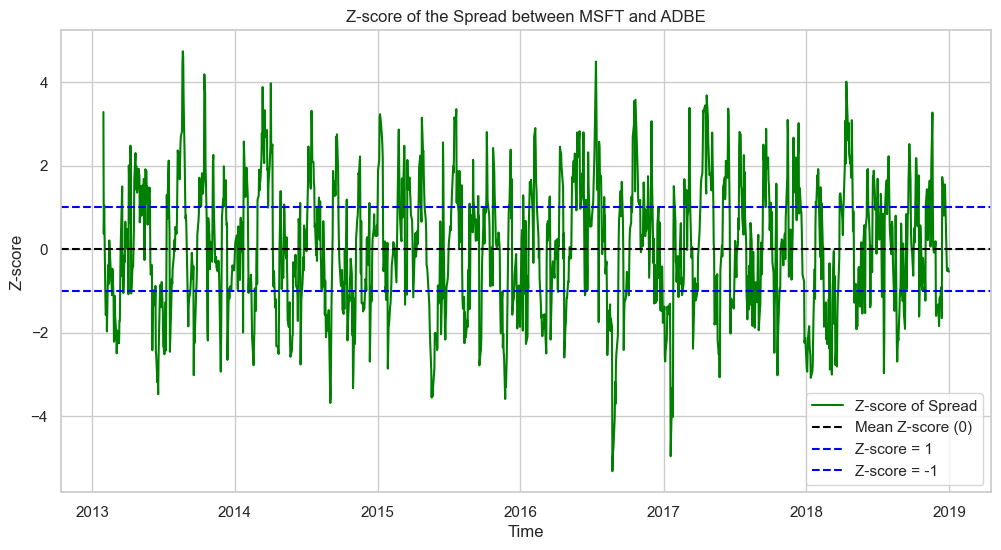

In [8]:
# Calculate rolling mean and standard deviation for spread
df['spread_mean'] = df['spread'].rolling(window=20).mean()
df['spread_std'] = df['spread'].rolling(window=10).std()

# Calculate z-score of the spread
df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# Plot the z-score of the spread
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['z_score'], label='Z-score of Spread', color='green')

# Add dotted lines for z-score of 0 and z-score of 1
plt.axhline(0, color='black', linestyle='--', label='Mean Z-score (0)')
plt.axhline(1, color='blue', linestyle='--', label='Z-score = 1')
plt.axhline(-1, color='blue', linestyle='--', label='Z-score = -1')

# Set the title and labels
plt.title('Z-score of the Spread between MSFT and ADBE')
plt.xlabel('Time')
plt.ylabel('Z-score')

# Show legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()


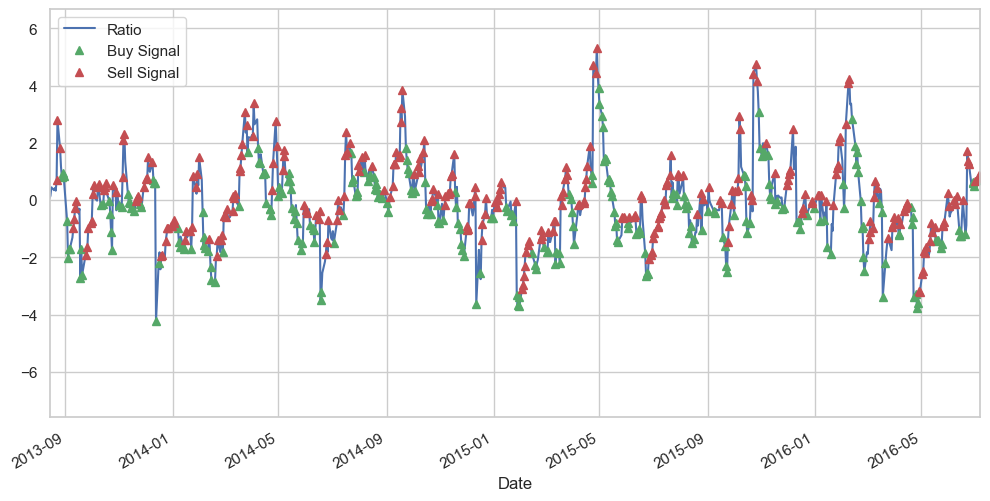

In [9]:
plt.figure(figsize=(12,6))
halflife = half_life(df['spread'])
df['spread_mean'] = df['spread'].rolling(window=halflife).mean()
df['spread_std'] = df['spread'].rolling(window=halflife).std()

df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']

train = df['spread']
train.plot()
buy = train.copy()
sell = train.copy()
buy[df['z_score'] > -0.5] = np.nan  # Corrected Buy signal condition
sell[df['z_score'] < 0.5] = np.nan  # Corrected Sell signal condition
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, df['spread'].min(), df['spread'].max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()


In [10]:
def trade(df, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation based on windows
    df['spread_mean'] = df['spread'].rolling(window=window1).mean()
    df['spread_std'] = df['spread'].rolling(window=window2).std()

    # Calculate z_score using the spread and rolling values
    df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    # Simulate trading
    money = 0
    countS1 = 0
    countS2 = 0

    # Loop through the DataFrame and simulate trading based on z-score
    for i in range(len(df)):
        # Sell short if the z-score is less than -1
        if df['z_score'][i] < -0.25:
            money += df['ADBE'][i] - df['MSFT'][i]  # Sell stock ADBE and buy MSFT
            countS1 -= 1
            countS2 += 1
        # Buy long if the z-score is greater than 1
        elif df['z_score'][i] > 0.25:
            money -= df['ADBE'][i] - df['MSFT'][i]  # Buy stock ADBE and sell MSFT
            countS1 += 1
            countS2 -= 1
        # Exit positions if the z-score is between -0.75 and 0.75
        elif abs(df['z_score'][i]) < 0.25:
            money += df['ADBE'][i] * countS1 + df['MSFT'][i] * countS2
            countS1 = 0
            countS2 = 0

    return money


In [11]:
trade(df, 60, 5)

np.float64(1337.1903476715088)

## Step 4: Backtesting

In [12]:
def backtest(x, y):
    df1 = pd.DataFrame({'y':y, 'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x), KalmanFilterAverage(y))
    df1['hr'] = -state_means[:, 0]
  
    df1['spread'] = df1['y'] + (df1['x'] * df1['hr'])

    # Now you can calculate rolling mean and standard deviation of the spread
    halflife = half_life(df1['spread'])
    meanSpread = df1['spread'].rolling(window=halflife).mean()
    stdSpread = df1['spread'].rolling(window=halflife).std()

    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    entryZscore = 1
    exitZscore = 0

    df1['long entry'] = ((df1.zScore < -entryZscore) & (df1.zScore.shift(1) > -entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
    df1['num units long'] = np.nan
    df1.loc[df1['long entry'],'num units long'] = 1
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1 

    try:
        sharpe = ((df1['port rets'].mean()/df1['port rets'].std()))*sqrt(252)
    except ZeroDivisionError:
        sharpe = 0.0

    return df1['cum rets'], sharpe

Perform out-sample testing if Sharpe ratio > 0.5 and CAGR > 10.5%.

In [14]:
x = df['ADBE']
y = df['MSFT']

tmp, sharpe = backtest(x, y)

print(sharpe)
print(tmp.values[-1])

0.8166974502447913
1.4787260955607655


## In Sample Backtesting

In [15]:
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

0.7280562835341613


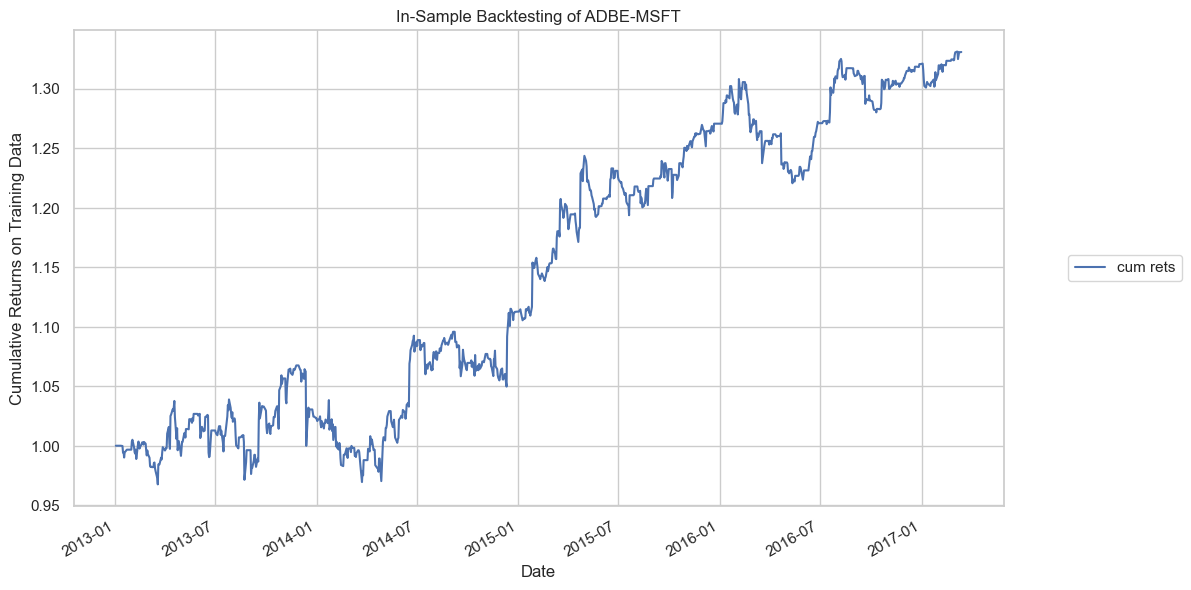

In [16]:
x_train = train_data['ADBE']
y_train = train_data['MSFT']
tmp_train, sharpe_train = backtest(x_train, y_train)
print(sharpe_train)
tmp_train.iloc[0] = 1
tmp_train.index = train_data.index
tmp_train.plot(figsize=(12,7), grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns on Training Data')
plt.title('In-Sample Backtesting of ADBE-MSFT')
plt.show()

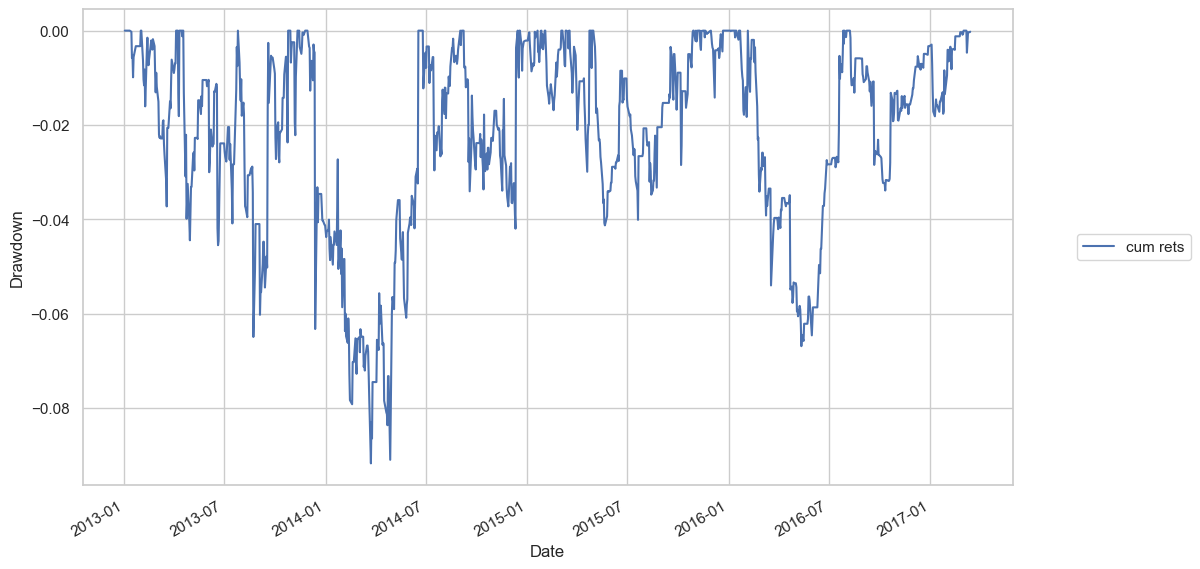

In [17]:
tmp_train.iloc[0] = 1
tmp_train.index = train_data.index
drawdown = ffn.to_drawdown_series(tmp_train)
drawdown.plot(figsize=(12,7), grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Drawdown')
plt.show()

In [18]:
perf_train = tmp_train.calc_stats()
print("Training Data Performance Statistics")
print(perf_train.stats)

Training Data Performance Statistics
start                    2013-01-02 00:00:00
end                      2017-03-14 00:00:00
rf                                       0.0
total_return                        0.330741
cagr                                0.070497
max_drawdown                       -0.091764
calmar                              0.768248
mtd                                 0.005268
three_month                         0.012771
six_month                           0.015396
ytd                                 0.007711
one_year                            0.052631
three_year                           0.10216
five_year                           0.070497
ten_year                                 NaN
incep                               0.070497
daily_sharpe                        0.734538
daily_sortino                       1.192281
daily_mean                           0.07315
daily_vol                           0.099586
daily_skew                          0.032031
daily_kurt        

## Out Sample Backtesting

1.8025213649582221


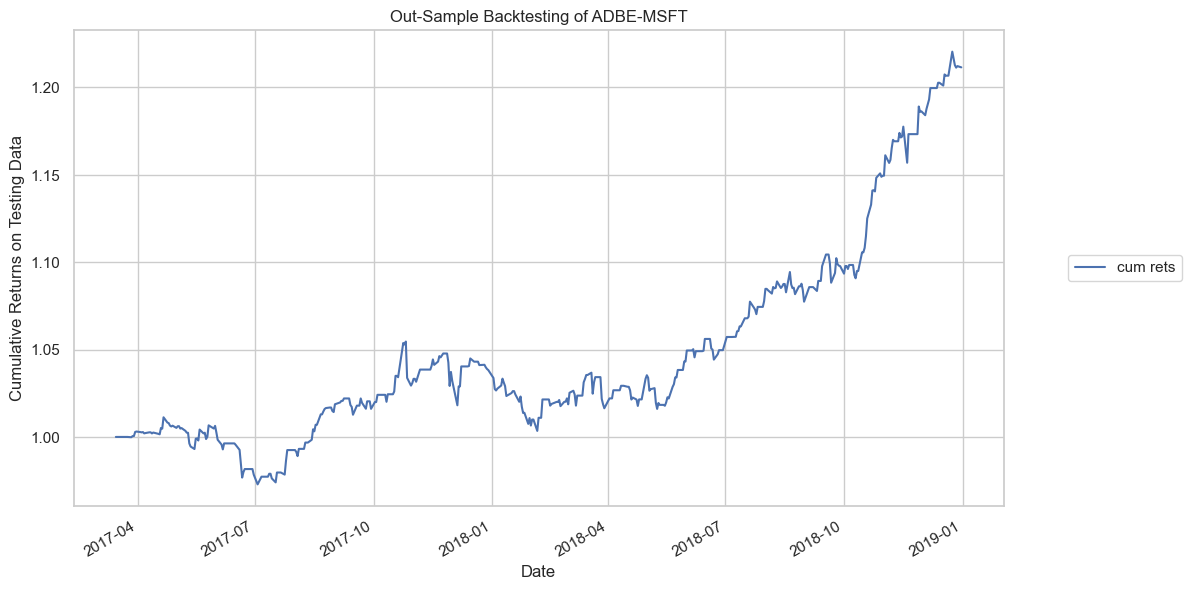

In [19]:
x_test = test_data['ADBE']
y_test = test_data['MSFT']
tmp_test, sharpe_test = backtest(x_test, y_test)
print(sharpe_test)
tmp_test.iloc[0] = 1
tmp_test.index = test_data.index
tmp_test.plot(figsize=(12,7), grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Cumulative Returns on Testing Data')
plt.title('Out-Sample Backtesting of ADBE-MSFT')
plt.show()

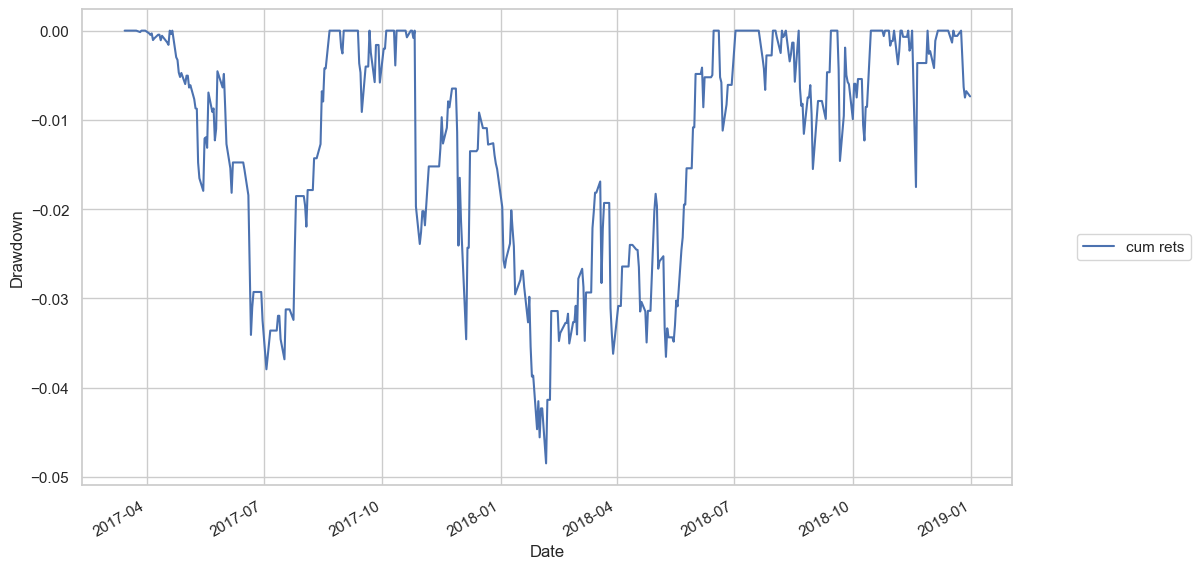

In [20]:
tmp_test.iloc[0] = 1
tmp_test.index = test_data.index
drawdown = ffn.to_drawdown_series(tmp_test)
drawdown.plot(figsize=(12,7), grid=True)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
plt.ylabel('Drawdown')
plt.show()

In [21]:
perf_test = tmp_test.calc_stats()
print("Testing Data Performance Statistics")
print(perf_test.stats)

Testing Data Performance Statistics
start                    2017-03-15 00:00:00
end                      2018-12-31 00:00:00
rf                                       0.0
total_return                        0.211481
cagr                                0.112729
max_drawdown                       -0.048492
calmar                              2.324668
mtd                                  0.02119
three_month                         0.103615
six_month                           0.154168
ytd                                 0.166858
one_year                            0.166858
three_year                               NaN
five_year                                NaN
ten_year                                 NaN
incep                               0.112729
daily_sharpe                        1.774044
daily_sortino                       3.004996
daily_mean                          0.108858
daily_vol                           0.061361
daily_skew                         -0.151752
daily_kurt         

## Observations 
### 1. **Total Return**
**In-Sample:** 33.07%  
**Out-of-Sample:** 21.15%  
**Analysis:**  
While total return decreases in the testing phase, this is expected because the testing data often includes unseen market conditions.  

### 2. **Daily Sharpe Ratio**
**In-Sample:** 0.735  
**Out-of-Sample:** 1.774  
**Analysis:**  
Sharpe Ratio improves significantly in testing, suggesting the strategy achieves higher risk-adjusted returns in unseen data.  

### 3. **Max Drawdown**
**In-Sample:** −9.18%  
**Out-of-Sample:** −4.85%  
**Analysis:**  
Lower drawdowns in testing indicate the strategy performs more consistently and is less risky in unseen data.  

### 4. **CAGR (Compound Annual Growth Rate)**
**In-Sample:** 7.05%  
**Out-of-Sample:** 11.27%  
**Analysis:**  
The out-of-sample CAGR exceeds the in-sample CAGR, indicating the method performs even better in testing than training.  

### 5. **Calmar Ratio**
**In-Sample:** 0.768  
**Out-of-Sample:** 2.325  
**Analysis:**  
The dramatic improvement in the Calmar ratio shows the strategy balances risk and reward better in testing, significantly outperforming in risk-adjusted terms.  

**This suggests the model is not overfitted and adapts well to unseen data.**
